In [46]:
%pip install pandas matplotlib -q
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3


[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [47]:
# Park id for thorpe park
park_id = 2

# Read into pandas df from sqlite fromm root directory, then date/queue_data.db
# Read the park_info and queue_data tables
conn = sqlite3.connect('../data/queue_data.db')
park_info = pd.read_sql_query(f"SELECT * FROM park_info WHERE park_id = {park_id}", conn)
queue_data = pd.read_sql_query("SELECT * FROM queue_data", conn)
conn.close()

# Convert the date column to datetime format
queue_data['date'] = pd.to_datetime(queue_data['date'], format='%Y/%m/%d')
# Convert the time column to timedelta format
queue_data['time_of_day'] = pd.to_datetime(queue_data['time_of_day'], format='%H:%M').dt.time
# Convert the queue_time column to numeric format
queue_data['queue_time'] = pd.to_numeric(queue_data['queue_time'], errors='coerce')
# Convert the is_closed numeric format to boolean
queue_data['is_closed'] = queue_data['is_closed'].astype(bool)

# Drop id columns
queue_data.drop(columns=['id'], inplace=True)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # Display the park_info DataFrame
    print("Park Info:")
    display(park_info)
    
# Display the queue_data DataFrame
print("\nQueue Data:")
display(queue_data)

Park Info:


,ride_id,park_id,ride_name
0,3884,2,Big Easy Bumpers
1,96,2,Colossus
2,108,2,Depth Charge
3,89,2,Detonator
4,95,2,Dobble Tea Party
5,93,2,Flying Fish
6,4546,2,Ghost Train
7,10711,2,High Striker
8,109,2,Mr Monkey's Banana Ride
9,88,2,Nemesis Inferno



Queue Data:


,date,ride_id,time_of_day,queue_time,is_closed
0,2024-03-23,3884,10:00:00,0,False
1,2024-03-23,3884,10:15:00,0,True
2,2024-03-23,3884,10:30:00,0,True
3,2024-03-23,3884,10:45:00,5,False
4,2024-03-23,3884,11:00:00,5,False
...,...,...,...,...,...
164815,2024-11-03,100,20:00:00,30,False
164816,2024-11-03,100,20:15:00,15,False
164817,2024-11-03,100,20:30:00,20,False
164818,2024-11-03,100,20:45:00,30,False


In [48]:
# List of main coasters
main_coasters = [
    'Stealth',
    'Nemesis Inferno',
    'Colossus',
    'Saw - The Ride',
    'The Swarm',
    'Hyperia'
]

# Filter the queue_data DataFrame for the main coasters using the id in the park_info DataFrame
coaster_ids = park_info[park_info['ride_name'].isin(main_coasters)]['ride_id'].tolist()
queue_data_filtered = queue_data[queue_data['ride_id'].isin(coaster_ids)]

# Display the filtered DataFrame
display(queue_data_filtered)

,date,ride_id,time_of_day,queue_time,is_closed
33,2024-03-23,96,10:00:00,0,False
34,2024-03-23,96,10:15:00,0,False
35,2024-03-23,96,10:30:00,0,False
36,2024-03-23,96,10:45:00,0,False
37,2024-03-23,96,11:00:00,20,False
...,...,...,...,...,...
164635,2024-11-03,103,20:00:00,70,False
164636,2024-11-03,103,20:15:00,70,False
164637,2024-11-03,103,20:30:00,70,False
164638,2024-11-03,103,20:45:00,40,False


In [49]:
# Filter the DataFrame where is_closed is False
open_queue_data = queue_data_filtered[~queue_data_filtered['is_closed']]

# Group by ride_id and time_of_day, then calculate the mean queue_time
average_queue_time = open_queue_data.groupby(['ride_id', 'time_of_day'])['queue_time'].mean().reset_index()

# Rename columns for clarity
average_queue_time.rename(columns={'queue_time': 'average_queue_time'}, inplace=True)

# Display the result
display(average_queue_time)

,ride_id,time_of_day,average_queue_time
0,103,10:00:00,2.868852
1,103,10:15:00,16.421053
2,103,10:30:00,19.800995
3,103,10:45:00,26.947115
4,103,11:00:00,35.000000
...,...,...,...
220,96,20:00:00,39.791667
221,96,20:15:00,30.000000
222,96,20:30:00,24.166667
223,96,20:45:00,24.130435


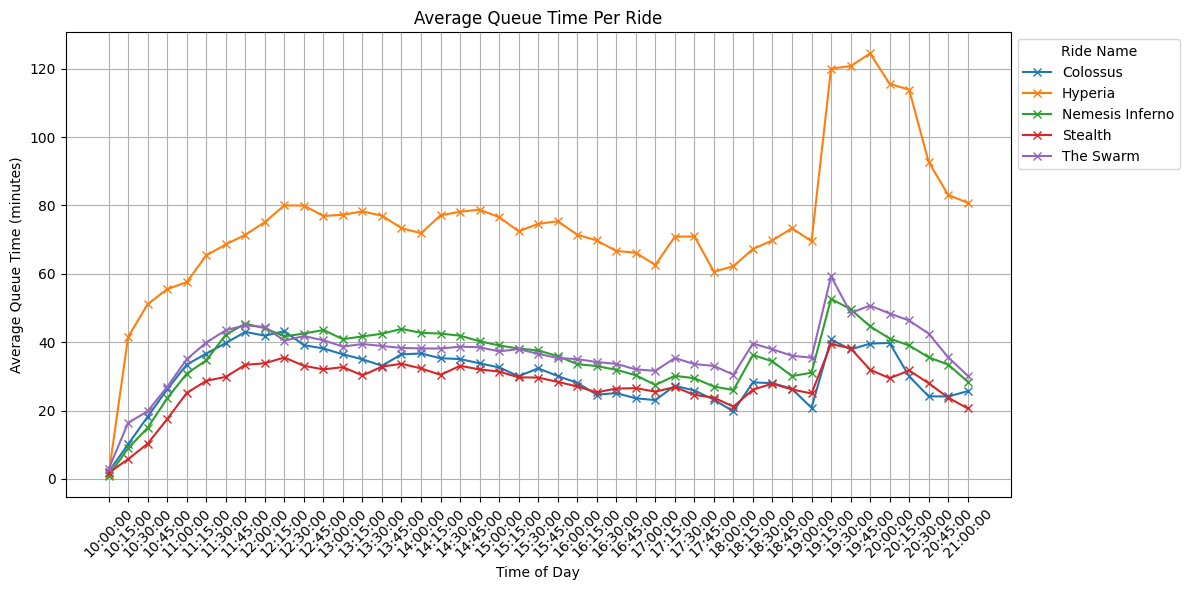

In [51]:
# Map ride_id to ride_name using the ride_name_mapping dictionary
average_queue_time['ride_name'] = average_queue_time['ride_id'].map(ride_name_mapping)

# Plot the data
plt.figure(figsize=(12, 6))
for ride_name, group in average_queue_time.groupby('ride_name'):
    plt.plot(group['time_of_day_str'], group['average_queue_time'], marker='x', label=ride_name)

# Add gridlines
plt.grid(True)

# Add labels and title
plt.xlabel('Time of Day')
plt.ylabel('Average Queue Time (minutes)')
plt.title('Average Queue Time Per Ride')

# Add legend
plt.legend(title='Ride Name', loc='upper left', bbox_to_anchor=(1, 1))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()